## Initial imports

In [1]:
import scm.plams as plams
import matplotlib.pyplot as plt
import numpy as np

## Molecule

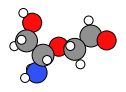

In [2]:
mol = plams.from_smiles("NC(CO)OCC=O")
plams.plot_molecule(mol);

## Engine settings

In [3]:
s = plams.Settings()
s.input.GFNFF  # GFN-FF force field
# s.input.MLPotential.Model = "AIMNet2-wB97MD3"   # new ml model in AMS2024

print(plams.AMSJob(settings=s).get_input())

# run in serial
s.runscript.nproc = 1

Engine GFNFF
EndEngine




## Some general parameters

In [4]:
T = 298  # temperature in K
max_freq = 4000  # plot spectrum up to 4000 cm^-1
max_dt_fs = 2000  # maximum correlation in fs for dipole derivative acf

## Equilibration

``temperature=(500, T, T)`` means that in the first half the simulation the system is cooled from 500 K to the gievn temperature, and then kept constant at that temperature.

The initial temperature of 500 K does some preliminary conformer search.

In [5]:
eq_job = plams.AMSNVTJob(
    settings=s,
    name="nvt_eq",
    molecule=mol,
    timestep=0.5,
    nsteps=10000,
    temperature=(500, T, T),
)
eq_job.run();

[18.02|08:09:28] JOB nvt_eq STARTED
[18.02|08:09:28] JOB nvt_eq RUNNING
[18.02|08:09:31] JOB nvt_eq FINISHED
[18.02|08:09:31] JOB nvt_eq SUCCESSFUL


## NVE production simulation

The ``binlog_dipolemoment`` option stores the dipole moment at every time step.

In [6]:
job = plams.AMSNVEJob.restart_from(
    eq_job,
    name="nve_single_prod",
    nsteps=50000,
    binlog_dipolemoment=True,
    binlog_time=True,
    samplingfreq=100,
    timestep=0.5,
)
job.run();

[18.02|08:09:31] JOB nve_single_prod STARTED
[18.02|08:09:31] JOB nve_single_prod RUNNING
[18.02|08:09:48] JOB nve_single_prod FINISHED
[18.02|08:09:48] JOB nve_single_prod SUCCESSFUL


## Dipole derivative autocorrelation function

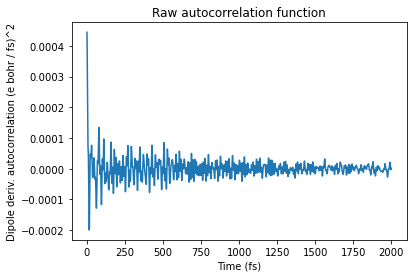

In [7]:
times, dipole_deriv_acf = job.results.get_dipole_derivatives_acf(start_fs=0, max_dt_fs=max_dt_fs)
plt.plot(times, dipole_deriv_acf)
plt.xlabel("Time (fs)")
plt.ylabel("Dipole deriv. autocorrelation (e bohr / fs)^2")
plt.title("Raw autocorrelation function");

Ideally, you should set ``max_dt_fs`` above to a large enough number so that the autocorrelation function decreases to a constant value of 0 (**and** have a long enough MD simulation to get enough statistics!)

## IR spectrum

The IR spectrum is the Fourier transform of the above autocorrelation function:

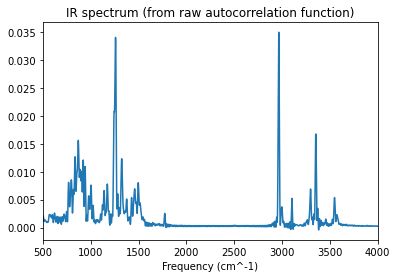

In [8]:
x_freq, y_intens_raw = job.results.get_ir_spectrum_md(times, dipole_deriv_acf, max_freq=max_freq)
plt.plot(x_freq, y_intens_raw)
plt.xlabel("Frequency (cm^-1)")
plt.title("IR spectrum (from raw autocorrelation function)")
plt.xlim(500, max_freq)
plt.show()

There seems to be quite some "noise" in the IR spectrum. One reason for this is that there is still some signal (or noise?) in the autocorrelation function at dt = 2000 fs.

However, it's also possible to use a tapering (window) function to make the autocorrelation function smoothly decrease to 0. This will make the resulting IR spectrum look a bit more tidy. See the next section.

## Tapering function for autocorrelation function

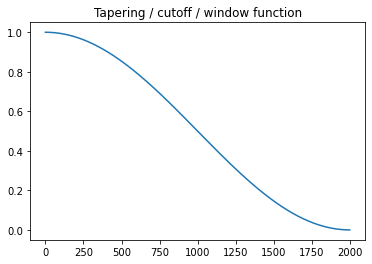

In [9]:
def tapered_cosine(x):
    return 0.5 * (np.cos(np.pi * x / np.max(x)) + 1)


plt.plot(times, tapered_cosine(times))
plt.title("Tapering / cutoff / window function");

Now apply this function to the autocorrelation function:

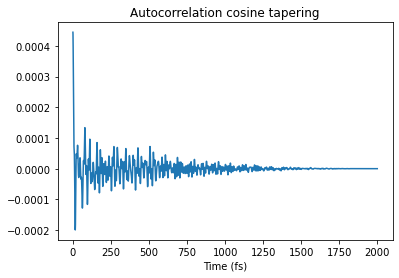

In [10]:
dipole_deriv_acf_tapered_cosine = dipole_deriv_acf * tapered_cosine(times)
plt.plot(times, dipole_deriv_acf_tapered_cosine)
plt.xlabel("Time (fs)")
plt.title("Autocorrelation cosine tapering");

And calculate the IR spectrum:

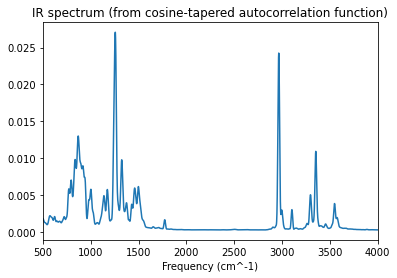

In [11]:
x_freq, y_intens_cosine = job.results.get_ir_spectrum_md(times, dipole_deriv_acf_tapered_cosine, max_freq=max_freq)
plt.plot(x_freq, y_intens_cosine)
plt.xlabel("Frequency (cm^-1)")
plt.title("IR spectrum (from cosine-tapered autocorrelation function)")
plt.xlim(500, max_freq);

Above we see that using the cosine-tapered autocorrelation function gives a smoother IR spectrum without affecting the intensities too much.

## Compare to IR spectrum calculated from harmonic approximation

Let's compare to an IR spectrum calculated with a geometry optimization + frequencies job, starting from the final frame of the MD simulation.

In [12]:
ams_s = plams.Settings()
ams_s.input.ams.Task = "GeometryOptimization"
ams_s.input.ams.Properties.NormalModes = "Yes"
harmonic_mol = job.results.get_main_molecule()
harmonic_job = plams.AMSJob(settings=ams_s + s, name="harmonic", molecule=harmonic_mol)
harmonic_job.run();

[18.02|08:09:49] JOB harmonic STARTED
[18.02|08:09:49] JOB harmonic RUNNING
[18.02|08:09:49] JOB harmonic FINISHED
[18.02|08:09:49] JOB harmonic SUCCESSFUL


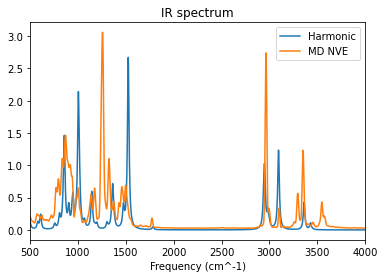

In [22]:
harmonic_freq, harmonic_intens = harmonic_job.results.get_ir_spectrum(broadening_type="lorentzian", broadening_width=20)
plt.plot(harmonic_freq, harmonic_intens)
rescale_factor = np.sum(harmonic_intens) / np.sum(y_intens_cosine)
plt.plot(x_freq, y_intens_cosine * rescale_factor)  # rescale
plt.legend(["Harmonic", "MD NVE"])
plt.title("IR spectrum")
plt.xlabel("Frequency (cm^-1)")
plt.xlim(500, max_freq);

In this case, the MD simulation samples multiple conformers so there are more peaks than for the harmonic calculation.

For example, the peak for the MD at 3600 cm^-1 corresponds to the "free" OH stretch of the hydroxyl group, but in conformer used for the  harmonic approximation the hydroxyl donates a hydrogen bond to the aldehyde oxygen (giving a lower vibrational frequency):

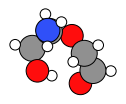

In [25]:
plams.plot_molecule(harmonic_job.results.get_main_molecule());

## View the trajectory in AMSmovie

In [24]:
!amsmovie "{job.results.rkfpath()}"

## View the normal modes in AMSspectra

In [23]:
!amsspectra "{harmonic_job.results.rkfpath(file='engine')}"

## Appendix: Average over multiple short NVE simulations

Best practice is to run multiple NVE simulations starting from different points of the NVT simulation, assuming that the NVT simulation samples the correct equilibrium distribution of structures/conformers.

Let's make this more explicit with another NVT simulation, followed by multiple NVE simulations from different points of the NVT simulation. See also the "Molecular Dynamics with Python" tutorial.

In [16]:
nvt_prod_job = plams.AMSNVTJob.restart_from(
    eq_job,
    name="nvt_prod",
    nsteps=50000,
    samplingfreq=100,
    timestep=0.5,
    thermostat="NHC",
    tau=100,
    temperature=T,
)
nvt_prod_job.run();

[18.02|08:10:03] JOB nvt_prod STARTED
[18.02|08:10:03] JOB nvt_prod RUNNING
[18.02|08:10:18] JOB nvt_prod FINISHED
[18.02|08:10:18] JOB nvt_prod SUCCESSFUL


In [17]:
nvespawner_job = plams.AMSNVESpawnerJob(
    nvt_prod_job,
    name="nvespawner-" + nvt_prod_job.name,
    n_nve=10,  # the number of NVE simulations to run
    timestep=0.5,
    binlog_time=True,
    binlog_dipolemoment=True,
    nsteps=20000,
)
nvespawner_job.run();

[18.02|08:10:18] JOB nvespawner-nvt_prod STARTED
[18.02|08:10:18] JOB nvespawner-nvt_prod RUNNING
[18.02|08:10:18] JOB nvespawner-nvt_prod/nve1 STARTED
[18.02|08:10:18] JOB nvespawner-nvt_prod/nve1 RUNNING
[18.02|08:10:25] JOB nvespawner-nvt_prod/nve1 FINISHED
[18.02|08:10:25] JOB nvespawner-nvt_prod/nve1 SUCCESSFUL
[18.02|08:10:25] JOB nvespawner-nvt_prod/nve2 STARTED
[18.02|08:10:25] JOB nvespawner-nvt_prod/nve2 RUNNING
[18.02|08:10:31] JOB nvespawner-nvt_prod/nve2 FINISHED
[18.02|08:10:32] JOB nvespawner-nvt_prod/nve2 SUCCESSFUL
[18.02|08:10:32] JOB nvespawner-nvt_prod/nve3 STARTED
[18.02|08:10:32] JOB nvespawner-nvt_prod/nve3 RUNNING
[18.02|08:10:38] JOB nvespawner-nvt_prod/nve3 FINISHED
[18.02|08:10:38] JOB nvespawner-nvt_prod/nve3 SUCCESSFUL
[18.02|08:10:38] JOB nvespawner-nvt_prod/nve4 STARTED
[18.02|08:10:38] JOB nvespawner-nvt_prod/nve4 RUNNING
[18.02|08:10:45] JOB nvespawner-nvt_prod/nve4 FINISHED
[18.02|08:10:45] JOB nvespawner-nvt_prod/nve4 SUCCESSFUL
[18.02|08:10:45] JOB n

Let's check that the temperature during the NVE is not too far from the requested temperature.

In [18]:
avg_T = nvespawner_job.results.get_mean_temperature()

print(f"Set temperature during NVT: {T:.1f} K")
print(f"Mean temperature during NVE: {avg_T:.1f}")

Set temperature during NVT: 298.0 K
Mean temperature during NVE: 277.8


Calculate the average dipole derivative autocorrelation function.

To calculate the IR spectrum from our custom set of averaged data, we directly call the ``power_spectrum`` function from PLAMS:

In [19]:
avg_x, avg_y = nvespawner_job.results.get_dipole_derivatives_acf(start_fs=0, max_dt_fs=max_dt_fs)
avg_y *= tapered_cosine(avg_x)

x_freq_multiple, y_intens_cosine_multiple = plams.trajectories.analysis.power_spectrum(times, avg_y, max_freq=max_freq)

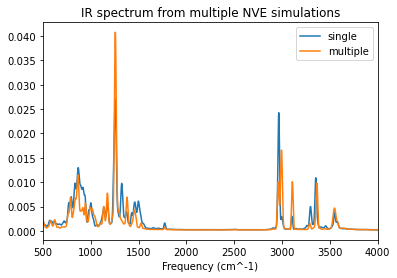

In [20]:
plt.plot(x_freq, y_intens_cosine)
plt.plot(x_freq_multiple, y_intens_cosine_multiple)
plt.xlabel("Frequency (cm^-1)")
plt.title("IR spectrum from multiple NVE simulations")
plt.legend(["single", "multiple"])
plt.xlim(500, 4000);